# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Sun Dec 13 01:49:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P8    12W / 151W |    315MiB /  8192MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
!dir "D:/Datasets/thesis_dr/aptos2019-blindness-detection/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019-blindness-detection

12/13/2020  01:48 AM    <DIR>          .
12/13/2020  01:48 AM    <DIR>          ..
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
12/06/2020  07:46 AM         1,235,300 df_train_duplicate.csv
12/10/2020  06:51 AM    <DIR>          models
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/18/2019  03:23 AM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/18/2019  03:27 AM            54,948 train.csv
10/10/2020  08:35 AM    <DIR>          train_images
10/30/2020  07:20 PM    <DIR>          train_images_balance_mini
10/28/2020  11:42 PM    <DIR>          train_images_jpeg
12/11/2020  01:07 AM    <DIR>          train_images_rescaled_300
12/06/2020  07:20 AM    <DIR>          train_images_rescaled_300_btgraham
12/11/2020  01:07 AM    <DIR>          

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019-blindness-detection/'
dir_img = os.path.join(
    dir_base, 'train_images_rescaled_300_btgraham')

if os.path.isdir(os.path.join(dir_base, 'models/kfold_btgraham/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_btgraham/'))

In [6]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
lr_tune = 2e-6
epoch_init = 50
epoch_tune = 50
# decay_init = lr_init / epoch_init
# decay_tune = lr_tune / epoch_tune
save_csv = 'log_training-20201213.csv'
save_EOE_train_head = 'EOE_classifier-20201213.h5'
save_best_train_head = 'best_classifier-20201213.h5'
save_EOE_train_body = 'EOE_fine_tune-20201213.h5'
save_best_train_body = 'best_fine_tune-20201213.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [8]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3493,ffa47f6a7bf4.png,2
3494,ffc04fed30e6.png,0
3495,ffcf7b45f213.png,2
3496,ffd97f8cd5aa.png,0


In [10]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [13]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [17]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights='imagenet', input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [18]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [19]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [20]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [21]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [22]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [23]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [24]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [25]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.png'

In [26]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.png,0


In [27]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

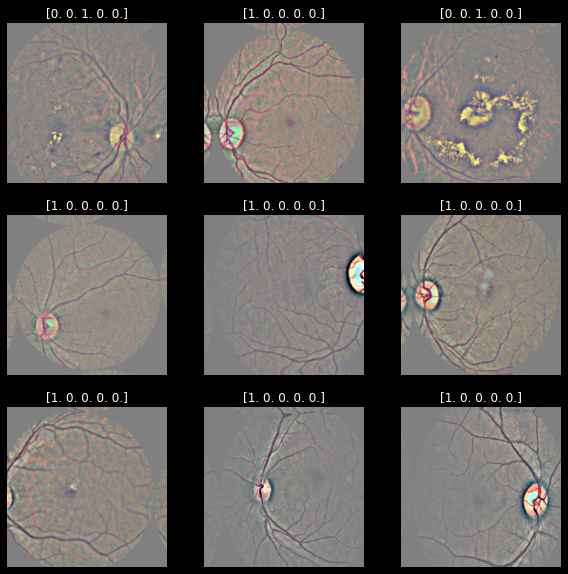

In [28]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [29]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [30]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [31]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.png'

In [32]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.png,0


In [33]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

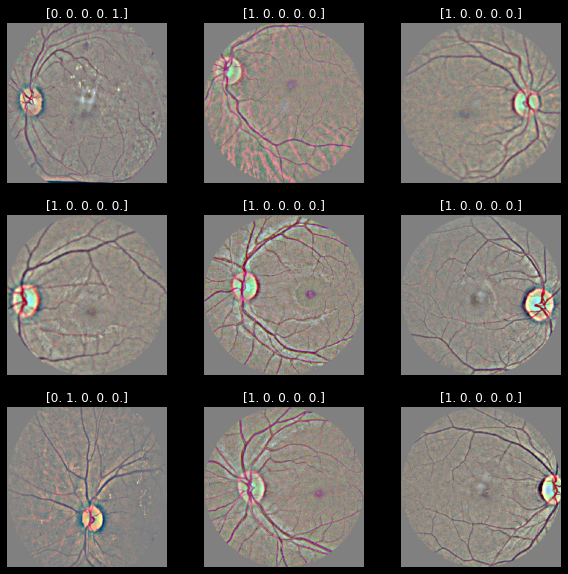

In [34]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [35]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [36]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.png,2
5,0083ee8054ee.png,4
9,00cb6555d108.png,1


In [37]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))

In [38]:
conv_base, model = create_model()

In [39]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [40]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [41]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 2s - loss: 10.8819 - categorical_accuracy: 0.4212 - precision: 0.4884 - recall: 0.3203 - auc: 0.7182
Epoch 00001: val_loss improved from inf to 10.09887, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold1\best_classifier-20201213.h5
88/88 [==============================] - 235s 3s/step - loss: 10.8841 - categorical_accuracy: 0.4224 - precision: 0.4888 - recall: 0.3209 - auc: 0.7191 - val_loss: 10.0989 - val_categorical_accuracy: 0.5400 - val_precision: 0.8421 - val_recall: 0.2286 - val_auc: 0.8195
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1764 - categorical_accuracy: 0.5304 - precision: 0.6099 - recall: 0.4454 - auc: 0.8104
Epoch 00002: val_loss improved from 10.09887 to 9.68538, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraha

88/88 [==============================] - 127s 1s/step - loss: 4.2922 - categorical_accuracy: 0.7034 - precision: 0.7826 - recall: 0.6380 - auc: 0.9312 - val_loss: 4.3307 - val_categorical_accuracy: 0.7100 - val_precision: 0.7975 - val_recall: 0.6300 - val_auc: 0.9348
Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 4.2250 - categorical_accuracy: 0.6847 - precision: 0.7595 - recall: 0.6164 - auc: 0.9234
Epoch 00028: val_loss improved from 4.33073 to 4.23398, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold1\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss: 4.2214 - categorical_accuracy: 0.6855 - precision: 0.7594 - recall: 0.6158 - auc: 0.9236 - val_loss: 4.2340 - val_categorical_accuracy: 0.7071 - val_precision: 0.7809 - val_recall: 0.6314 - val_auc: 0.9345
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 4.0821 - categorical_accuracy: 0.6938 - precision: 0.7659

In [42]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

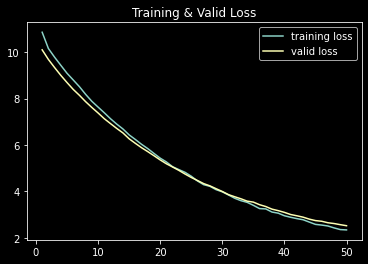

In [43]:
plot_loss(history)

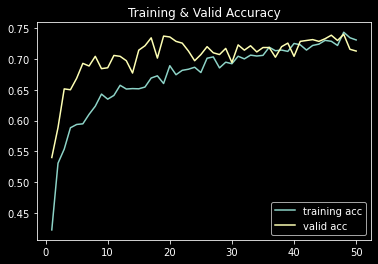

In [44]:
plot_acc(history)

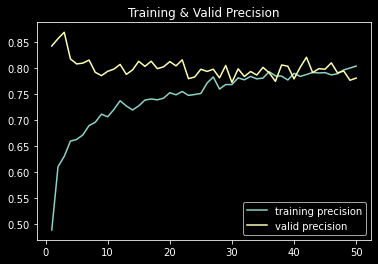

In [45]:
plot_precision(history)

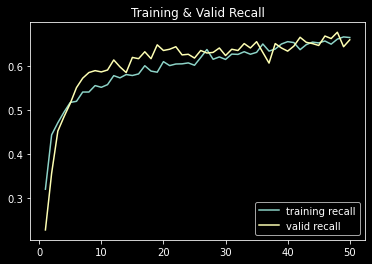

In [46]:
plot_recall(history)

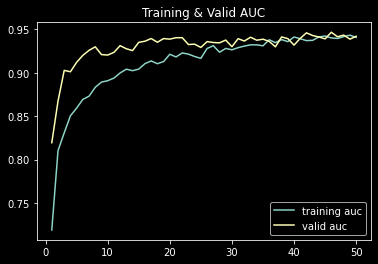

In [47]:
plot_auc(history)

### Evaluate model

In [48]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 539ms/step - loss: 2.1685 - categorical_accuracy: 0.7129 - precision: 0.7804 - recall: 0.6600 - auc: 0.9420


[2.168539621613242, 0.7128571, 0.7804054, 0.66, 0.9420085]

In [49]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [50]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 489ms/step


In [51]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.97      0.96       359
         mild       0.43      0.51      0.47        67
     moderate       0.69      0.40      0.51       185
       severe       0.23      0.57      0.33        35
proliferative       0.38      0.43      0.40        54

     accuracy                           0.71       700
    macro avg       0.54      0.57      0.53       700
 weighted avg       0.75      0.71      0.72       700



In [52]:
confusion_matrix(y_true, y_pred)

array([[348,   9,   2,   0,   0],
       [ 11,  34,  16,   2,   4],
       [  5,  32,  74,  47,  27],
       [  1,   1,   7,  20,   6],
       [  1,   3,   9,  18,  23]], dtype=int64)

## Fine Tune

In [53]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [55]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [56]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.3015 - categorical_accuracy: 0.7339 - precision: 0.8040 - recall: 0.6631 - auc: 0.9440
Epoch 00001: val_loss improved from inf to 2.51121, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold1\best_fine_tune-20201213.h5
88/88 [==============================] - 143s 2s/step - loss: 2.3004 - categorical_accuracy: 0.7334 - precision: 0.8034 - recall: 0.6630 - auc: 0.9437 - val_loss: 2.5112 - val_categorical_accuracy: 0.7129 - val_precision: 0.7864 - val_recall: 0.6629 - val_auc: 0.9427
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.2635 - categorical_accuracy: 0.7444 - precision: 0.8127 - recall: 0.6826 - auc: 0.9477
Epoch 00002: val_loss improved from 2.51121 to 2.50444, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold1

Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.1484 - categorical_accuracy: 0.7693 - precision: 0.8343 - recall: 0.7025 - auc: 0.9577
Epoch 00016: val_loss did not improve from 2.47371
88/88 [==============================] - 125s 1s/step - loss: 2.1476 - categorical_accuracy: 0.7691 - precision: 0.8340 - recall: 0.7023 - auc: 0.9577 - val_loss: 2.4751 - val_categorical_accuracy: 0.7171 - val_precision: 0.7776 - val_recall: 0.6643 - val_auc: 0.9417
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 2.1456 - categorical_accuracy: 0.7733 - precision: 0.8237 - recall: 0.6974 - auc: 0.9574
Epoch 00017: val_loss did not improve from 2.47371
88/88 [==============================] - 128s 1s/step - loss: 2.1469 - categorical_accuracy: 0.7731 - precision: 0.8239 - recall: 0.6973 - auc: 0.9573 - val_loss: 2.4754 - val_categorical_accuracy: 0.7200 - val_precision: 0.7780 - val_recall: 0.6657 - val_auc: 0.9428
Epoch 18/50
87/88 [===========================

88/88 [==============================] - 130s 1s/step - loss: 2.0525 - categorical_accuracy: 0.7873 - precision: 0.8336 - recall: 0.7341 - auc: 0.9626 - val_loss: 2.4249 - val_categorical_accuracy: 0.7514 - val_precision: 0.7942 - val_recall: 0.7000 - val_auc: 0.9491
Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 2.0409 - categorical_accuracy: 0.8040 - precision: 0.8525 - recall: 0.7458 - auc: 0.9650
Epoch 00047: val_loss did not improve from 2.42491
88/88 [==============================] - 125s 1s/step - loss: 2.0386 - categorical_accuracy: 0.8034 - precision: 0.8522 - recall: 0.7459 - auc: 0.9651 - val_loss: 2.4267 - val_categorical_accuracy: 0.7557 - val_precision: 0.7932 - val_recall: 0.7014 - val_auc: 0.9493
Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 2.0220 - categorical_accuracy: 0.7950 - precision: 0.8483 - recall: 0.7422 - auc: 0.9651
Epoch 00048: val_loss improved from 2.42491 to 2.42103, saving model to D:/Datasets/thesis_dr/apt

In [57]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

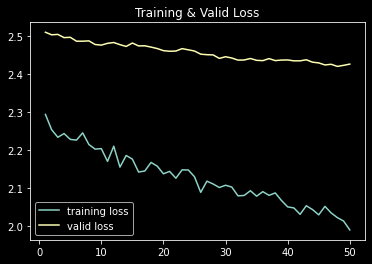

In [58]:
plot_loss(history)

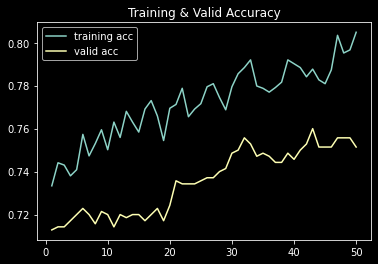

In [59]:
plot_acc(history)

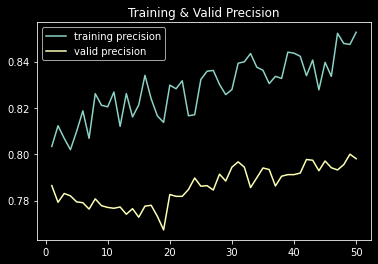

In [60]:
plot_precision(history)

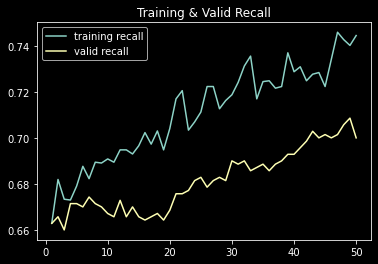

In [61]:
plot_recall(history)

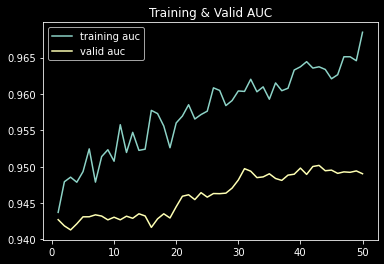

In [62]:
plot_auc(history)

### Evaluate model

In [63]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 546ms/step - loss: 2.0638 - categorical_accuracy: 0.7514 - precision: 0.7980 - recall: 0.7000 - auc: 0.9490


[2.063838866623965, 0.75142854, 0.7980456, 0.7, 0.9490329]

In [64]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [65]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 488ms/step


In [66]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.98      0.97       359
         mild       0.48      0.61      0.54        67
     moderate       0.73      0.48      0.58       185
       severe       0.25      0.51      0.34        35
proliferative       0.48      0.50      0.49        54

     accuracy                           0.75       700
    macro avg       0.58      0.62      0.58       700
 weighted avg       0.78      0.75      0.76       700



In [67]:
confusion_matrix(y_true, y_pred)

array([[352,   7,   0,   0,   0],
       [  9,  41,  14,   2,   1],
       [  4,  32,  88,  39,  22],
       [  0,   2,   9,  18,   6],
       [  1,   3,  10,  13,  27]], dtype=int64)

# Fold 2

## Train classifier

In [68]:
del(model)

In [69]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [70]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.png,4
3,002c21358ce6.png,0
11,00e4ddff966a.png,2


In [71]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))

In [72]:
conv_base, model = create_model()

In [73]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [74]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [75]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.8280 - categorical_accuracy: 0.4273 - precision: 0.5047 - recall: 0.3319 - auc: 0.7230
Epoch 00001: val_loss improved from inf to 10.09541, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold2\best_classifier-20201213.h5
88/88 [==============================] - 141s 2s/step - loss: 10.8222 - categorical_accuracy: 0.4296 - precision: 0.5068 - recall: 0.3331 - auc: 0.7245 - val_loss: 10.0954 - val_categorical_accuracy: 0.5314 - val_precision: 0.8519 - val_recall: 0.2300 - val_auc: 0.8106
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1874 - categorical_accuracy: 0.5206 - precision: 0.6023 - recall: 0.4342 - auc: 0.8005
Epoch 00002: val_loss improved from 10.09541 to 9.69556, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraha

88/88 [==============================] - 128s 1s/step - loss: 4.1912 - categorical_accuracy: 0.6866 - precision: 0.7593 - recall: 0.6133 - auc: 0.9242 - val_loss: 4.1469 - val_categorical_accuracy: 0.7414 - val_precision: 0.8283 - val_recall: 0.6271 - val_auc: 0.9450
Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 4.0032 - categorical_accuracy: 0.7144 - precision: 0.7824 - recall: 0.6291 - auc: 0.9321
Epoch 00028: val_loss improved from 4.14692 to 4.05008, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold2\best_classifier-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 4.0035 - categorical_accuracy: 0.7141 - precision: 0.7817 - recall: 0.6283 - auc: 0.9320 - val_loss: 4.0501 - val_categorical_accuracy: 0.7271 - val_precision: 0.8062 - val_recall: 0.6300 - val_auc: 0.9406
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8942 - categorical_accuracy: 0.7050 - precision: 0.7737

In [76]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

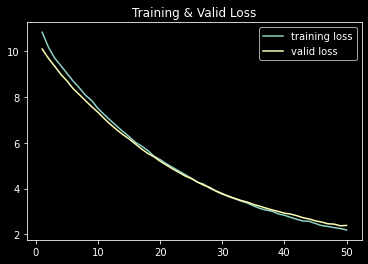

In [77]:
plot_loss(history)

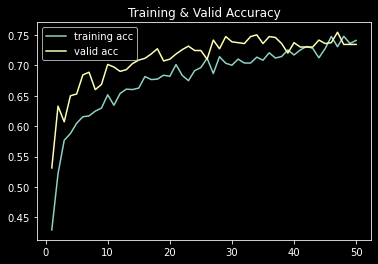

In [78]:
plot_acc(history)

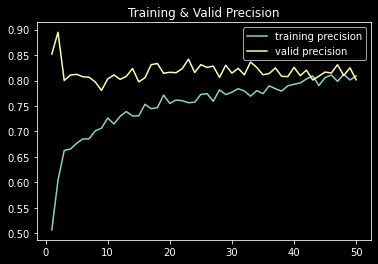

In [79]:
plot_precision(history)

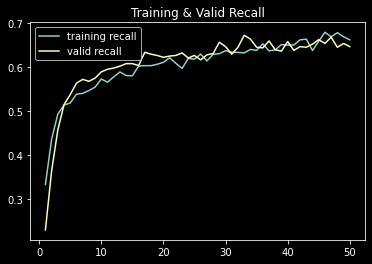

In [80]:
plot_recall(history)

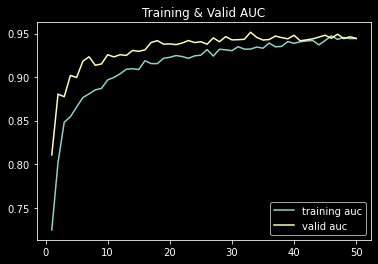

In [81]:
plot_auc(history)

### Evaluate model

In [82]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 548ms/step - loss: 2.0334 - categorical_accuracy: 0.7343 - precision: 0.8014 - recall: 0.6457 - auc: 0.9444


[2.0333642797036604, 0.7342857, 0.8014184, 0.6457143, 0.944436]

In [83]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [84]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 492ms/step


In [85]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.92      0.99      0.96       359
         mild       0.47      0.41      0.44        68
     moderate       0.80      0.45      0.57       184
       severe       0.25      0.60      0.35        35
proliferative       0.40      0.50      0.44        54

     accuracy                           0.73       700
    macro avg       0.57      0.59      0.55       700
 weighted avg       0.77      0.73      0.73       700



In [86]:
confusion_matrix(y_true, y_pred)

array([[356,   2,   0,   1,   0],
       [ 17,  28,  12,   3,   8],
       [ 11,  20,  82,  48,  23],
       [  0,   1,   3,  21,  10],
       [  2,   8,   6,  11,  27]], dtype=int64)

## Fine Tune

In [87]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [88]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [89]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [90]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1304 - categorical_accuracy: 0.7422 - precision: 0.8051 - recall: 0.6735 - auc: 0.9480
Epoch 00001: val_loss improved from inf to 2.37987, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold2\best_fine_tune-20201213.h5
88/88 [==============================] - 144s 2s/step - loss: 2.1290 - categorical_accuracy: 0.7427 - precision: 0.8060 - recall: 0.6741 - auc: 0.9482 - val_loss: 2.3799 - val_categorical_accuracy: 0.7386 - val_precision: 0.8111 - val_recall: 0.6500 - val_auc: 0.9456
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1348 - categorical_accuracy: 0.7419 - precision: 0.8065 - recall: 0.6750 - auc: 0.9463
Epoch 00002: val_loss improved from 2.37987 to 2.36585, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold2

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.0628 - categorical_accuracy: 0.7585 - precision: 0.8202 - recall: 0.6978 - auc: 0.9539
Epoch 00015: val_loss improved from 2.31967 to 2.31221, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold2\best_fine_tune-20201213.h5
88/88 [==============================] - 131s 1s/step - loss: 2.0609 - categorical_accuracy: 0.7584 - precision: 0.8206 - recall: 0.6980 - auc: 0.9541 - val_loss: 2.3122 - val_categorical_accuracy: 0.7543 - val_precision: 0.8213 - val_recall: 0.6829 - val_auc: 0.9517
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0532 - categorical_accuracy: 0.7668 - precision: 0.8263 - recall: 0.7032 - auc: 0.9551
Epoch 00016: val_loss improved from 2.31221 to 2.31172, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold2\best_fine_tune-20201213.h5
88/88 [==============================] - 130s 1s/step - lo

Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 1.9744 - categorical_accuracy: 0.7791 - precision: 0.8331 - recall: 0.7180 - auc: 0.9607
Epoch 00030: val_loss did not improve from 2.28863
88/88 [==============================] - 126s 1s/step - loss: 1.9748 - categorical_accuracy: 0.7781 - precision: 0.8317 - recall: 0.7173 - auc: 0.9605 - val_loss: 2.2889 - val_categorical_accuracy: 0.7614 - val_precision: 0.8276 - val_recall: 0.6929 - val_auc: 0.9540
Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.9737 - categorical_accuracy: 0.7852 - precision: 0.8365 - recall: 0.7234 - auc: 0.9618
Epoch 00031: val_loss did not improve from 2.28863
88/88 [==============================] - 127s 1s/step - loss: 1.9739 - categorical_accuracy: 0.7845 - precision: 0.8364 - recall: 0.7234 - auc: 0.9618 - val_loss: 2.2886 - val_categorical_accuracy: 0.7543 - val_precision: 0.8256 - val_recall: 0.6900 - val_auc: 0.9535
Epoch 32/50
87/88 [===========================

88/88 [==============================] - 130s 1s/step - loss: 1.9236 - categorical_accuracy: 0.7945 - precision: 0.8460 - recall: 0.7402 - auc: 0.9654 - val_loss: 2.2714 - val_categorical_accuracy: 0.7600 - val_precision: 0.8256 - val_recall: 0.7100 - val_auc: 0.9554
Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.9376 - categorical_accuracy: 0.7903 - precision: 0.8394 - recall: 0.7314 - auc: 0.9643
Epoch 00046: val_loss did not improve from 2.27136
88/88 [==============================] - 127s 1s/step - loss: 1.9371 - categorical_accuracy: 0.7895 - precision: 0.8387 - recall: 0.7305 - auc: 0.9642 - val_loss: 2.2789 - val_categorical_accuracy: 0.7571 - val_precision: 0.8248 - val_recall: 0.7129 - val_auc: 0.9555
Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 1.9293 - categorical_accuracy: 0.7946 - precision: 0.8432 - recall: 0.7346 - auc: 0.9646
Epoch 00047: val_loss improved from 2.27136 to 2.26568, saving model to D:/Datasets/thesis_dr/apt

In [91]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

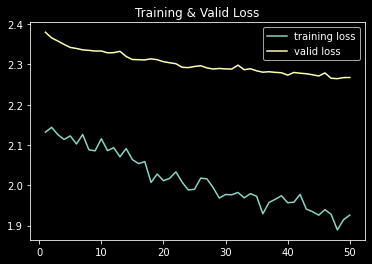

In [92]:
plot_loss(history)

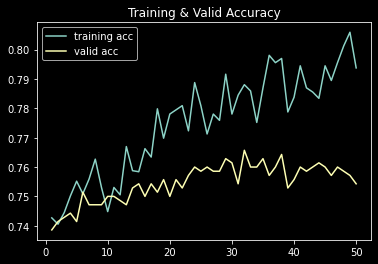

In [93]:
plot_acc(history)

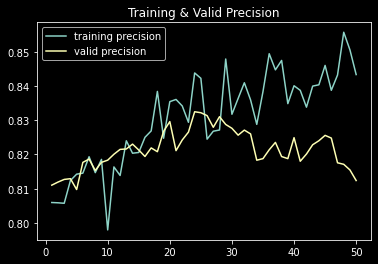

In [94]:
plot_precision(history)

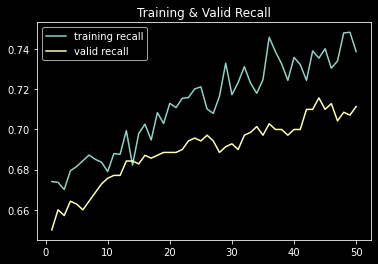

In [95]:
plot_recall(history)

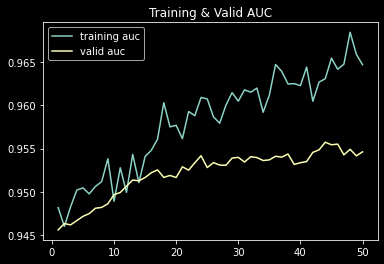

In [96]:
plot_auc(history)

### Evaluate model

In [97]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 546ms/step - loss: 1.9051 - categorical_accuracy: 0.7543 - precision: 0.8124 - recall: 0.7114 - auc: 0.9546


[1.9050763899629766, 0.7542857, 0.812398, 0.7114286, 0.9546273]

In [98]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [99]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 489ms/step


In [100]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.99      0.98       359
         mild       0.48      0.65      0.55        68
     moderate       0.76      0.48      0.59       184
       severe       0.28      0.51      0.36        35
proliferative       0.37      0.39      0.38        54

     accuracy                           0.75       700
    macro avg       0.57      0.61      0.57       700
 weighted avg       0.78      0.75      0.76       700



In [101]:
confusion_matrix(y_true, y_pred)

array([[356,   3,   0,   0,   0],
       [  8,  44,  11,   2,   3],
       [  5,  32,  89,  35,  23],
       [  0,   0,   7,  18,  10],
       [  1,  13,  10,   9,  21]], dtype=int64)

# Fold 3

## Train classifier

In [102]:
del(model)

In [103]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [104]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.png,1
12,00f6c1be5a33.png,0
18,0151781fe50b.png,0


In [105]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))

In [106]:
conv_base, model = create_model()

In [107]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [108]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [109]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.8304 - categorical_accuracy: 0.4364 - precision: 0.5058 - recall: 0.3333 - auc: 0.7226
Epoch 00001: val_loss improved from inf to 10.18108, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold3\best_classifier-20201213.h5
88/88 [==============================] - 140s 2s/step - loss: 10.8261 - categorical_accuracy: 0.4375 - precision: 0.5076 - recall: 0.3345 - auc: 0.7233 - val_loss: 10.1811 - val_categorical_accuracy: 0.6214 - val_precision: 0.8411 - val_recall: 0.3100 - val_auc: 0.8523
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1603 - categorical_accuracy: 0.5380 - precision: 0.6171 - recall: 0.4364 - auc: 0.8121
Epoch 00002: val_loss improved from 10.18108 to 9.78034, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraha

88/88 [==============================] - 128s 1s/step - loss: 4.2582 - categorical_accuracy: 0.6984 - precision: 0.7710 - recall: 0.6090 - auc: 0.9236 - val_loss: 4.3583 - val_categorical_accuracy: 0.7200 - val_precision: 0.7950 - val_recall: 0.6314 - val_auc: 0.9369
Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 4.0848 - categorical_accuracy: 0.7072 - precision: 0.7796 - recall: 0.6330 - auc: 0.9298
Epoch 00028: val_loss improved from 4.35834 to 4.20345, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold3\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss: 4.0817 - categorical_accuracy: 0.7051 - precision: 0.7781 - recall: 0.6315 - auc: 0.9295 - val_loss: 4.2034 - val_categorical_accuracy: 0.7157 - val_precision: 0.7985 - val_recall: 0.6171 - val_auc: 0.9352
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.9521 - categorical_accuracy: 0.7079 - precision: 0.7723

In [110]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

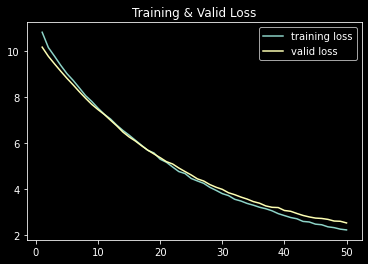

In [111]:
plot_loss(history)

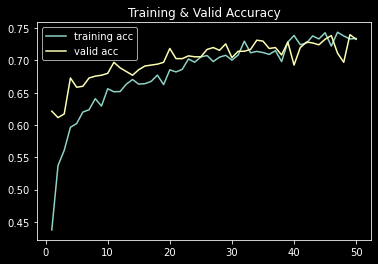

In [112]:
plot_acc(history)

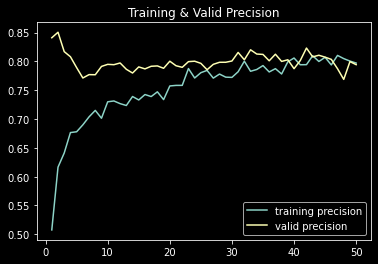

In [113]:
plot_precision(history)

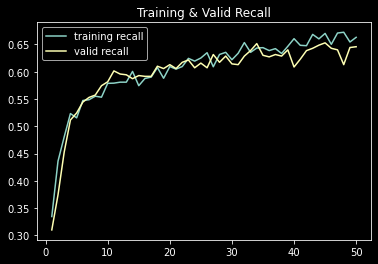

In [114]:
plot_recall(history)

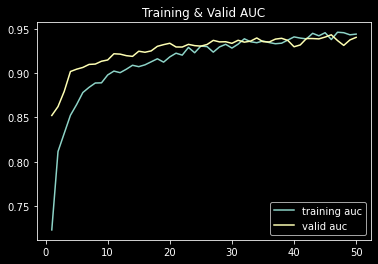

In [115]:
plot_auc(history)

### Evaluate model

In [116]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 549ms/step - loss: 2.0956 - categorical_accuracy: 0.7329 - precision: 0.7944 - recall: 0.6457 - auc: 0.9403


[2.095569746060805, 0.73285717, 0.7943761, 0.6457143, 0.9402646]

In [117]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [118]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 491ms/step


In [119]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.90      0.98      0.94       359
         mild       0.39      0.41      0.40        68
     moderate       0.73      0.52      0.61       184
       severe       0.26      0.43      0.32        35
proliferative       0.46      0.43      0.44        54

     accuracy                           0.73       700
    macro avg       0.55      0.55      0.54       700
 weighted avg       0.74      0.73      0.73       700



In [120]:
confusion_matrix(y_true, y_pred)

array([[351,   6,   1,   1,   0],
       [ 19,  28,  14,   3,   4],
       [ 15,  30,  96,  30,  13],
       [  2,   3,   5,  15,  10],
       [  2,   5,  15,   9,  23]], dtype=int64)

## Fine Tune

In [121]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [122]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [123]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [124]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1638 - categorical_accuracy: 0.7372 - precision: 0.8082 - recall: 0.6732 - auc: 0.9475
Epoch 00001: val_loss improved from inf to 2.53497, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold3\best_fine_tune-20201213.h5
88/88 [==============================] - 144s 2s/step - loss: 2.1723 - categorical_accuracy: 0.7362 - precision: 0.8067 - recall: 0.6712 - auc: 0.9471 - val_loss: 2.5350 - val_categorical_accuracy: 0.7300 - val_precision: 0.7983 - val_recall: 0.6557 - val_auc: 0.9406
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1812 - categorical_accuracy: 0.7343 - precision: 0.8030 - recall: 0.6706 - auc: 0.9451
Epoch 00002: val_loss improved from 2.53497 to 2.52794, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold3

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.0854 - categorical_accuracy: 0.7596 - precision: 0.8276 - recall: 0.6992 - auc: 0.9536
Epoch 00015: val_loss did not improve from 2.45936
88/88 [==============================] - 133s 2s/step - loss: 2.0827 - categorical_accuracy: 0.7605 - precision: 0.8284 - recall: 0.7005 - auc: 0.9540 - val_loss: 2.4668 - val_categorical_accuracy: 0.7357 - val_precision: 0.8014 - val_recall: 0.6571 - val_auc: 0.9442
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0884 - categorical_accuracy: 0.7737 - precision: 0.8268 - recall: 0.7093 - auc: 0.9563
Epoch 00016: val_loss did not improve from 2.45936
88/88 [==============================] - 135s 2s/step - loss: 2.0897 - categorical_accuracy: 0.7727 - precision: 0.8262 - recall: 0.7084 - auc: 0.9560 - val_loss: 2.4598 - val_categorical_accuracy: 0.7443 - val_precision: 0.8007 - val_recall: 0.6600 - val_auc: 0.9442
Epoch 17/50
87/88 [===========================

87/88 [============================>.] - ETA: 1s - loss: 1.9468 - categorical_accuracy: 0.8062 - precision: 0.8576 - recall: 0.7487 - auc: 0.9666
Epoch 00045: val_loss did not improve from 2.41182
88/88 [==============================] - 126s 1s/step - loss: 1.9499 - categorical_accuracy: 0.8041 - precision: 0.8550 - recall: 0.7462 - auc: 0.9663 - val_loss: 2.4152 - val_categorical_accuracy: 0.7543 - val_precision: 0.8044 - val_recall: 0.6814 - val_auc: 0.9480
Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.9744 - categorical_accuracy: 0.8030 - precision: 0.8513 - recall: 0.7451 - auc: 0.9656
Epoch 00046: val_loss improved from 2.41182 to 2.41024, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold3\best_fine_tune-20201213.h5
88/88 [==============================] - 131s 1s/step - loss: 1.9738 - categorical_accuracy: 0.8020 - precision: 0.8498 - recall: 0.7441 - auc: 0.9652 - val_loss: 2.4102 - val_categorical_accuracy: 

In [125]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

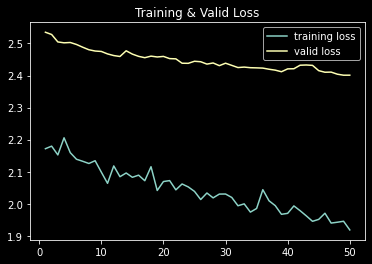

In [126]:
plot_loss(history)

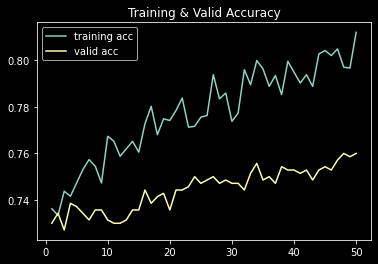

In [127]:
plot_acc(history)

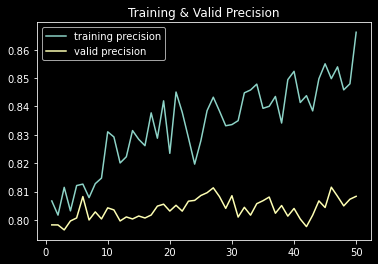

In [128]:
plot_precision(history)

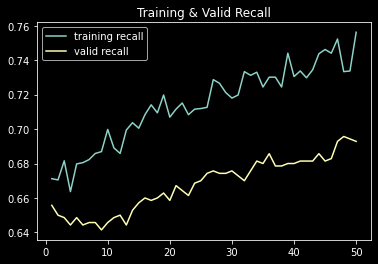

In [129]:
plot_recall(history)

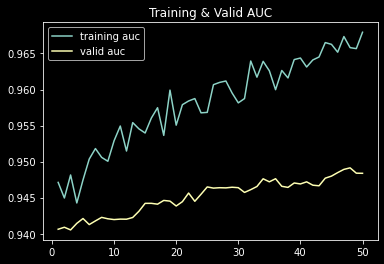

In [130]:
plot_auc(history)

### Evaluate model

In [131]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 573ms/step - loss: 1.9811 - categorical_accuracy: 0.7600 - precision: 0.8083 - recall: 0.6929 - auc: 0.9484


[1.981104558164423, 0.76, 0.80833334, 0.69285715, 0.9483788]

In [132]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [133]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 493ms/step


In [134]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.98      0.96       359
         mild       0.48      0.56      0.52        68
     moderate       0.74      0.54      0.63       184
       severe       0.31      0.49      0.38        35
proliferative       0.45      0.46      0.46        54

     accuracy                           0.76       700
    macro avg       0.58      0.61      0.59       700
 weighted avg       0.77      0.76      0.76       700



In [135]:
confusion_matrix(y_true, y_pred)

array([[352,   6,   0,   1,   0],
       [ 11,  38,  14,   3,   2],
       [ 10,  29, 100,  27,  18],
       [  1,   2,   5,  17,  10],
       [  2,   4,  16,   7,  25]], dtype=int64)

# Fold 4

## Train classifier

In [136]:
del(model)

In [137]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [138]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.png,0
10,00cc2b75cddd.png,0
13,0104b032c141.png,3


In [139]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))

In [140]:
conv_base, model = create_model()

In [141]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [142]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [143]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.8158 - categorical_accuracy: 0.4514 - precision: 0.5179 - recall: 0.3498 - auc: 0.7344
Epoch 00001: val_loss improved from inf to 10.13607, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold4\best_classifier-20201213.h5
88/88 [==============================] - 206s 2s/step - loss: 10.8221 - categorical_accuracy: 0.4512 - precision: 0.5182 - recall: 0.3501 - auc: 0.7340 - val_loss: 10.1361 - val_categorical_accuracy: 0.5136 - val_precision: 0.7959 - val_recall: 0.2232 - val_auc: 0.8012
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1918 - categorical_accuracy: 0.5360 - precision: 0.5947 - recall: 0.4391 - auc: 0.8023
Epoch 00002: val_loss improved from 10.13607 to 9.72496, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraha

88/88 [==============================] - 137s 2s/step - loss: 4.2059 - categorical_accuracy: 0.6985 - precision: 0.7808 - recall: 0.6274 - auc: 0.9291 - val_loss: 4.2954 - val_categorical_accuracy: 0.7139 - val_precision: 0.7841 - val_recall: 0.6338 - val_auc: 0.9334
Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 4.0641 - categorical_accuracy: 0.6975 - precision: 0.7696 - recall: 0.6267 - auc: 0.9306
Epoch 00028: val_loss improved from 4.29538 to 4.14273, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold4\best_classifier-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 4.0689 - categorical_accuracy: 0.6974 - precision: 0.7688 - recall: 0.6259 - auc: 0.9304 - val_loss: 4.1427 - val_categorical_accuracy: 0.7167 - val_precision: 0.8018 - val_recall: 0.6366 - val_auc: 0.9363
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.9024 - categorical_accuracy: 0.7145 - precision: 0.7819

In [144]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

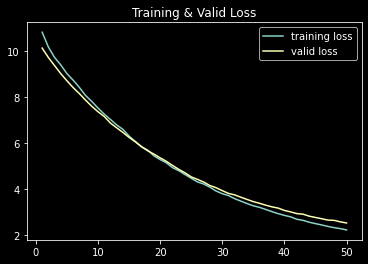

In [145]:
plot_loss(history)

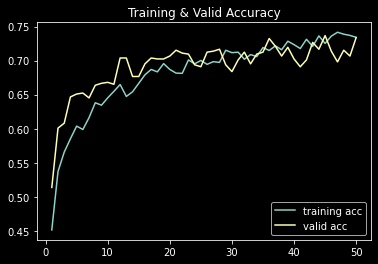

In [146]:
plot_acc(history)

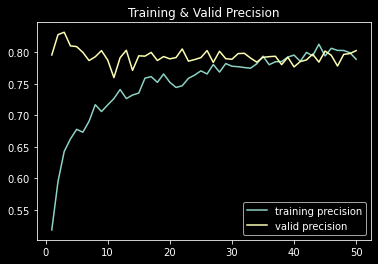

In [147]:
plot_precision(history)

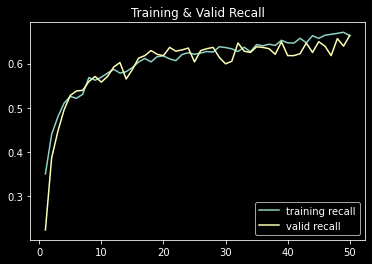

In [148]:
plot_recall(history)

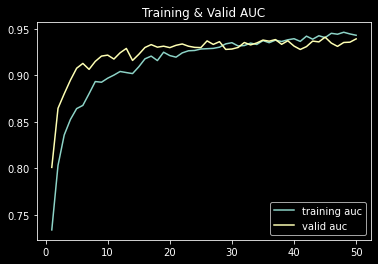

In [149]:
plot_auc(history)

### Evaluate model

In [150]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 16s 711ms/step - loss: 2.0870 - categorical_accuracy: 0.7339 - precision: 0.8028 - recall: 0.6638 - auc: 0.9393


[2.087003453211351, 0.73390555, 0.8027682, 0.6638054, 0.9393036]

In [151]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [152]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 494ms/step


In [153]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.93      0.97      0.95       359
         mild       0.53      0.49      0.51        68
     moderate       0.67      0.53      0.59       184
       severe       0.24      0.47      0.31        34
proliferative       0.37      0.35      0.36        54

     accuracy                           0.73       699
    macro avg       0.55      0.56      0.54       699
 weighted avg       0.75      0.73      0.74       699



In [154]:
confusion_matrix(y_true, y_pred)

array([[348,   5,   5,   1,   0],
       [  8,  33,  22,   3,   2],
       [ 15,  18,  97,  32,  22],
       [  1,   1,   8,  16,   8],
       [  1,   5,  13,  16,  19]], dtype=int64)

## Fine Tune

In [155]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [156]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [157]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [158]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1533 - categorical_accuracy: 0.7405 - precision: 0.8035 - recall: 0.6755 - auc: 0.9479
Epoch 00001: val_loss improved from inf to 2.50763, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold4\best_fine_tune-20201213.h5
88/88 [==============================] - 144s 2s/step - loss: 2.1545 - categorical_accuracy: 0.7413 - precision: 0.8041 - recall: 0.6760 - auc: 0.9480 - val_loss: 2.5076 - val_categorical_accuracy: 0.7339 - val_precision: 0.7959 - val_recall: 0.6695 - val_auc: 0.9396
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1711 - categorical_accuracy: 0.7459 - precision: 0.8057 - recall: 0.6773 - auc: 0.9473
Epoch 00002: val_loss improved from 2.50763 to 2.50248, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold4

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.0677 - categorical_accuracy: 0.7705 - precision: 0.8245 - recall: 0.7029 - auc: 0.9570
Epoch 00015: val_loss improved from 2.46551 to 2.45824, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold4\best_fine_tune-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 2.0648 - categorical_accuracy: 0.7699 - precision: 0.8236 - recall: 0.7020 - auc: 0.9569 - val_loss: 2.4582 - val_categorical_accuracy: 0.7411 - val_precision: 0.7960 - val_recall: 0.6810 - val_auc: 0.9425
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0412 - categorical_accuracy: 0.7705 - precision: 0.8230 - recall: 0.7073 - auc: 0.9574
Epoch 00016: val_loss did not improve from 2.45824
88/88 [==============================] - 127s 1s/step - loss: 2.0390 - categorical_accuracy: 0.7710 - precision: 0.8241 - recall: 0.7081 - auc: 0.9576 - val_loss: 2.4598 - val_categorica

Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.9437 - categorical_accuracy: 0.7998 - precision: 0.8436 - recall: 0.7405 - auc: 0.9653
Epoch 00046: val_loss improved from 2.40643 to 2.40484, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold4\best_fine_tune-20201213.h5
88/88 [==============================] - 129s 1s/step - loss: 1.9438 - categorical_accuracy: 0.8003 - precision: 0.8442 - recall: 0.7417 - auc: 0.9654 - val_loss: 2.4048 - val_categorical_accuracy: 0.7654 - val_precision: 0.8086 - val_recall: 0.7010 - val_auc: 0.9474
Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 1.9001 - categorical_accuracy: 0.8027 - precision: 0.8446 - recall: 0.7524 - auc: 0.9666
Epoch 00047: val_loss did not improve from 2.40484
88/88 [==============================] - 126s 1s/step - loss: 1.9035 - categorical_accuracy: 0.8017 - precision: 0.8440 - recall: 0.7521 - auc: 0.9664 - val_loss: 2.4153 - val_categorica

In [159]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

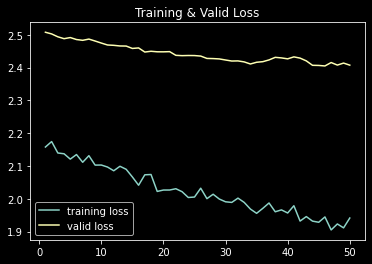

In [160]:
plot_loss(history)

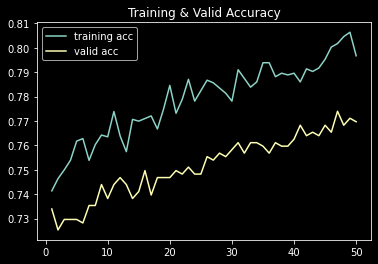

In [161]:
plot_acc(history)

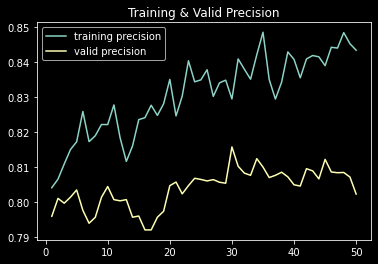

In [162]:
plot_precision(history)

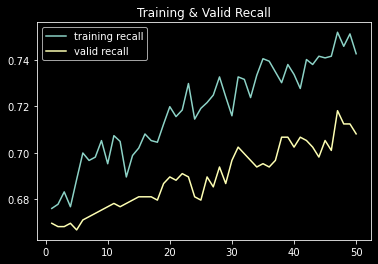

In [163]:
plot_recall(history)

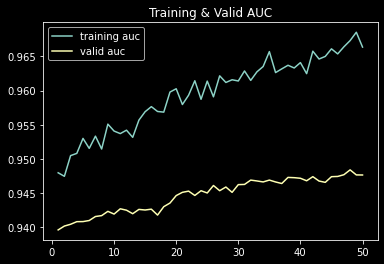

In [164]:
plot_auc(history)

### Evaluate model

In [165]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 552ms/step - loss: 1.9819 - categorical_accuracy: 0.7697 - precision: 0.8023 - recall: 0.7082 - auc: 0.9476


[1.9819437644698403, 0.76967096, 0.80226904, 0.7081545, 0.9476368]

In [166]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [167]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 495ms/step


In [168]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.97      0.97       359
         mild       0.51      0.60      0.55        68
     moderate       0.75      0.57      0.65       184
       severe       0.38      0.53      0.44        34
proliferative       0.38      0.44      0.41        54

     accuracy                           0.77       699
    macro avg       0.59      0.62      0.60       699
 weighted avg       0.79      0.77      0.77       699



In [169]:
confusion_matrix(y_true, y_pred)

array([[350,   6,   0,   2,   1],
       [  6,  41,  17,   1,   3],
       [  9,  25, 105,  17,  28],
       [  1,   1,   6,  18,   8],
       [  0,   8,  12,  10,  24]], dtype=int64)

# Fold 5

## Train classifier

In [170]:
del(model)

In [171]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [172]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.png,0
7,00a8624548a9.png,2
8,00b74780d31d.png,2


In [173]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_btgraham/fold'+str(fold))

In [174]:
conv_base, model = create_model()

In [175]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [176]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [177]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7557 - categorical_accuracy: 0.4507 - precision: 0.5209 - recall: 0.3509 - auc: 0.7424
Epoch 00001: val_loss improved from inf to 10.18800, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold5\best_classifier-20201213.h5
88/88 [==============================] - 141s 2s/step - loss: 10.7441 - categorical_accuracy: 0.4519 - precision: 0.5217 - recall: 0.3519 - auc: 0.7438 - val_loss: 10.1880 - val_categorical_accuracy: 0.6609 - val_precision: 0.8478 - val_recall: 0.4063 - val_auc: 0.8741
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1710 - categorical_accuracy: 0.5432 - precision: 0.6274 - recall: 0.4539 - auc: 0.8131
Epoch 00002: val_loss improved from 10.18800 to 9.67300, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraha

88/88 [==============================] - 129s 1s/step - loss: 4.1460 - categorical_accuracy: 0.6999 - precision: 0.7730 - recall: 0.6302 - auc: 0.9316 - val_loss: 4.2122 - val_categorical_accuracy: 0.6924 - val_precision: 0.7959 - val_recall: 0.6080 - val_auc: 0.9344
Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9969 - categorical_accuracy: 0.7022 - precision: 0.7711 - recall: 0.6393 - auc: 0.9313
Epoch 00028: val_loss improved from 4.21223 to 4.09403, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold5\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss: 4.0022 - categorical_accuracy: 0.7013 - precision: 0.7711 - recall: 0.6392 - auc: 0.9312 - val_loss: 4.0940 - val_categorical_accuracy: 0.7182 - val_precision: 0.8058 - val_recall: 0.6352 - val_auc: 0.9403
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8625 - categorical_accuracy: 0.7008 - precision: 0.7744

In [178]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

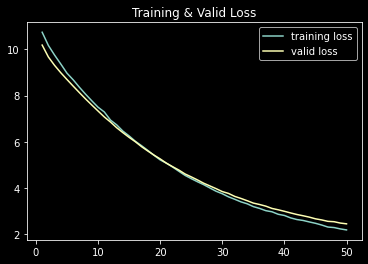

In [179]:
plot_loss(history)

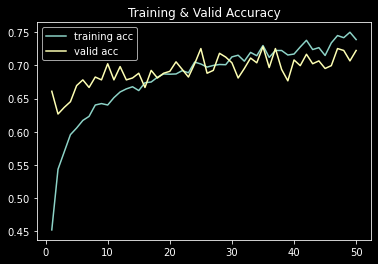

In [180]:
plot_acc(history)

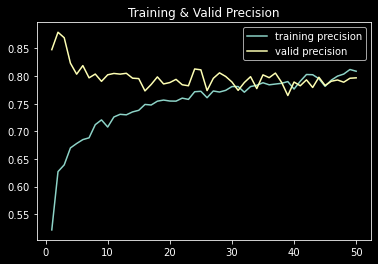

In [181]:
plot_precision(history)

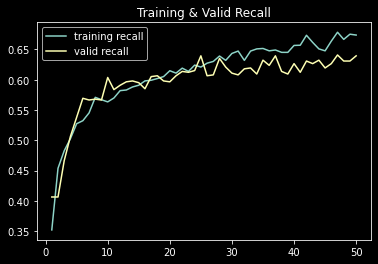

In [182]:
plot_recall(history)

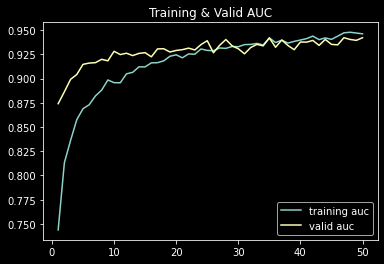

In [183]:
plot_auc(history)

### Evaluate model

In [184]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 16s 746ms/step - loss: 2.0496 - categorical_accuracy: 0.7225 - precision: 0.7968 - recall: 0.6395 - auc: 0.9421


[2.049567796967246, 0.7224607, 0.79679143, 0.639485, 0.9421253]

In [185]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [186]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 496ms/step


In [187]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.93      0.97      0.95       360
         mild       0.43      0.57      0.49        67
     moderate       0.77      0.41      0.53       184
       severe       0.20      0.35      0.26        34
proliferative       0.41      0.56      0.47        54

     accuracy                           0.72       699
    macro avg       0.54      0.57      0.54       699
 weighted avg       0.76      0.72      0.72       699



In [188]:
confusion_matrix(y_true, y_pred)

array([[350,   7,   2,   0,   1],
       [ 16,  38,   8,   2,   3],
       [ 11,  33,  75,  35,  30],
       [  0,   5,   7,  12,  10],
       [  1,   6,   6,  11,  30]], dtype=int64)

## Fine Tune

In [189]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [190]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [191]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [192]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1193 - categorical_accuracy: 0.7481 - precision: 0.8152 - recall: 0.6729 - auc: 0.9497
Epoch 00001: val_loss improved from inf to 2.46370, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold5\best_fine_tune-20201213.h5
88/88 [==============================] - 143s 2s/step - loss: 2.1180 - categorical_accuracy: 0.7474 - precision: 0.8154 - recall: 0.6724 - auc: 0.9495 - val_loss: 2.4637 - val_categorical_accuracy: 0.7368 - val_precision: 0.7944 - val_recall: 0.6466 - val_auc: 0.9428
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1393 - categorical_accuracy: 0.7503 - precision: 0.8115 - recall: 0.6784 - auc: 0.9484
Epoch 00002: val_loss improved from 2.46370 to 2.45225, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold5

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.0288 - categorical_accuracy: 0.7654 - precision: 0.8245 - recall: 0.7080 - auc: 0.9580
Epoch 00015: val_loss did not improve from 2.40083
88/88 [==============================] - 127s 1s/step - loss: 2.0290 - categorical_accuracy: 0.7660 - precision: 0.8256 - recall: 0.7085 - auc: 0.9582 - val_loss: 2.4059 - val_categorical_accuracy: 0.7124 - val_precision: 0.7732 - val_recall: 0.6438 - val_auc: 0.9420
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0568 - categorical_accuracy: 0.7738 - precision: 0.8226 - recall: 0.7055 - auc: 0.9552
Epoch 00016: val_loss improved from 2.40083 to 2.39830, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold5\best_fine_tune-20201213.h5
88/88 [==============================] - 132s 2s/step - loss: 2.0539 - categorical_accuracy: 0.7749 - precision: 0.8230 - recall: 0.7060 - auc: 0.9554 - val_loss: 2.3983 - val_categorica

88/88 [==============================] - 131s 1s/step - loss: 2.0063 - categorical_accuracy: 0.7753 - precision: 0.8274 - recall: 0.7160 - auc: 0.9598 - val_loss: 2.3730 - val_categorical_accuracy: 0.7368 - val_precision: 0.7892 - val_recall: 0.6695 - val_auc: 0.9465
Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.9732 - categorical_accuracy: 0.7842 - precision: 0.8365 - recall: 0.7232 - auc: 0.9630
Epoch 00031: val_loss did not improve from 2.37296
88/88 [==============================] - 127s 1s/step - loss: 1.9741 - categorical_accuracy: 0.7853 - precision: 0.8376 - recall: 0.7242 - auc: 0.9632 - val_loss: 2.3752 - val_categorical_accuracy: 0.7339 - val_precision: 0.7879 - val_recall: 0.6695 - val_auc: 0.9465
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.9766 - categorical_accuracy: 0.7893 - precision: 0.8368 - recall: 0.7394 - auc: 0.9626
Epoch 00032: val_loss did not improve from 2.37296
88/88 [==============================] - 127s 

88/88 [==============================] - 189s 2s/step - loss: 1.9051 - categorical_accuracy: 0.7921 - precision: 0.8414 - recall: 0.7471 - auc: 0.9657 - val_loss: 2.3558 - val_categorical_accuracy: 0.7496 - val_precision: 0.7941 - val_recall: 0.6896 - val_auc: 0.9472
Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 1.8853 - categorical_accuracy: 0.8075 - precision: 0.8496 - recall: 0.7550 - auc: 0.9687
Epoch 00047: val_loss improved from 2.35578 to 2.35347, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_btgraham/fold5\best_fine_tune-20201213.h5
88/88 [==============================] - 167s 2s/step - loss: 1.8817 - categorical_accuracy: 0.8081 - precision: 0.8501 - recall: 0.7556 - auc: 0.9689 - val_loss: 2.3535 - val_categorical_accuracy: 0.7482 - val_precision: 0.7921 - val_recall: 0.6867 - val_auc: 0.9490
Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.9074 - categorical_accuracy: 0.8023 - precision: 0.8522 

In [193]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

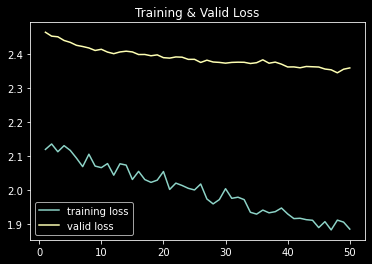

In [194]:
plot_loss(history)

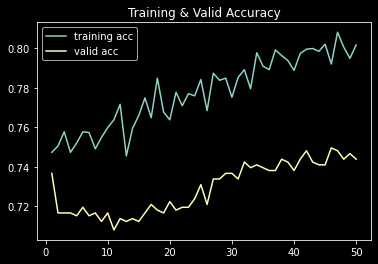

In [195]:
plot_acc(history)

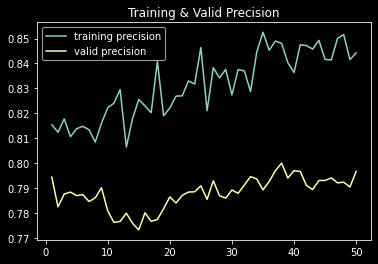

In [196]:
plot_precision(history)

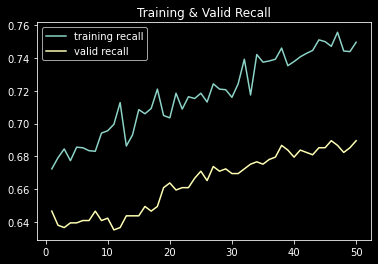

In [197]:
plot_recall(history)

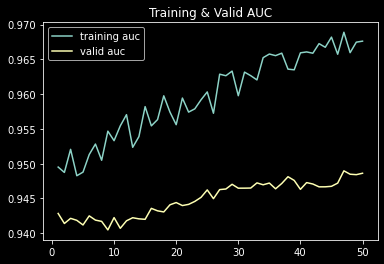

In [198]:
plot_auc(history)

### Evaluate model

In [199]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 565ms/step - loss: 1.9499 - categorical_accuracy: 0.7439 - precision: 0.7967 - recall: 0.6896 - auc: 0.9486


[1.9499088309027932, 0.7439199, 0.7966942, 0.68955654, 0.9486304]

In [200]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [201]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 499ms/step


In [202]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.97      0.95       360
         mild       0.45      0.55      0.49        67
     moderate       0.75      0.48      0.58       184
       severe       0.25      0.41      0.31        34
proliferative       0.44      0.57      0.50        54

     accuracy                           0.74       699
    macro avg       0.57      0.60      0.57       699
 weighted avg       0.77      0.74      0.75       699



In [203]:
confusion_matrix(y_true, y_pred)

array([[350,   6,   3,   0,   1],
       [ 13,  37,  13,   2,   2],
       [  9,  31,  88,  30,  26],
       [  0,   3,   7,  14,  10],
       [  1,   6,   7,   9,  31]], dtype=int64)